In [1]:
%matplotlib inline
import subprocess as sp
import sys
from collections import defaultdict
import numpy as np
import re
import matplotlib.pylab as plt
from ulf import ulf

In [2]:
def standarize_plot_parameters():
    # http://scipy.github.io/old-wiki/pages/Cookbook/Matplotlib/LaTeX_Examples
    # thesis has 417.47 points in column size, with 0.6\columnwidth
    fig_width_pt = 417.47*0.6
    inches_per_pt = 1.0/72.27               # Convert pt to inches
    golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
    fig_width = fig_width_pt*inches_per_pt  # width in inches
    fig_height = fig_width*golden_mean       # height in inches
    params = {
        'axes.labelsize': 10,
        'legend.fontsize': 7,
        'xtick.labelsize': 8,
        'ytick.labelsize': 8,
        'figure.figsize': [fig_width, fig_height],
        'font.family': 'STIXGeneral',  # close enough to LaTeX font
        'font.size': 8,
        'figure.frameon': False
    }
    plt.rcParams.update(params)
standarize_plot_parameters()

# Analytical

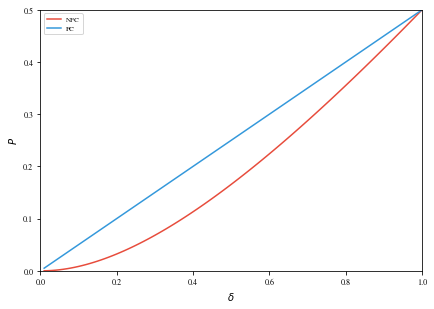

In [9]:
def p_fc(delta, r):
    """Probability of switching layer with full coupling (FC)."""
    return 0.5 * delta * r

def p_nfc(delta, r, N, rho=1):
    """Probability of switching layer with neighborhood flow coupling (NFC)."""
    return delta * r * ((rho * N * delta - 1) * 1.0 / ((rho * N * delta - 1) + (N - 1)))

N, r = 100, 1.0
deltas = np.linspace(1.0 / N, 1, N)
rho = 1

a_an, b_an = [], []
for delta in deltas:
    a_an.append(p_fc(delta, r))
    b_an.append(p_nfc(delta, r, N, rho))
    
plt.figure(figsize=(3.42/2.0*4, 1.2*4), frameon=False)
# plt.subplot(1, 2, 1)
plt.plot(deltas, b_an, label="NFC", c="#e74c3c")
plt.plot(deltas, a_an, label="FC", c="#3498db")
plt.xlabel("$\delta$"); plt.ylabel("$P$")
plt.xlim(0, 1); plt.ylim(0, 0.5)
plt.xticks(np.linspace(0, 1.0, 6))
plt.yticks(np.linspace(0, 0.5, 6))
plt.legend()
# plt.subplot(1, 2, 2)
# plt.plot(b_an, a_an, c="k")
# plt.xlabel("$P_{NFC}$", fontsize=12); plt.ylabel("$P_{FC}$", fontsize=12)
# plt.xlim(0, ); plt.ylim(0, 0.5)
#plt.savefig("../figures/delta_versus_p_analyt.pdf")
plt.show()

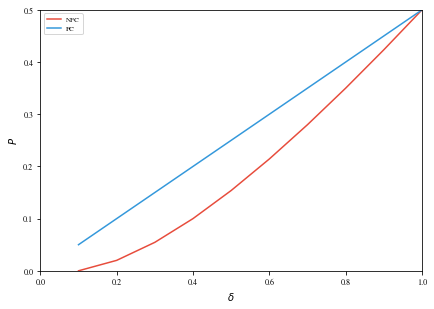

In [17]:
N, r = 10, 1.0
deltas = np.linspace(1.0 / N, 1, N)
rho = 1

a_an, b_an = [], []
for delta in deltas:
    a_an.append(p_fc(delta, r))
    b_an.append(p_nfc(delta, r, N, rho))
    
plt.figure(figsize=(3.42/2.0*4, 1.2*4), frameon=False)
# plt.subplot(1, 2, 1)
plt.plot(deltas, b_an, label="NFC", c="#e74c3c")
plt.plot(deltas, a_an, label="FC", c="#3498db")
plt.xlabel("$\delta$"); plt.ylabel("$P$")
plt.xlim(0, 1); plt.ylim(0, 0.5)
plt.xticks(np.linspace(0, 1.0, 6))
plt.yticks(np.linspace(0, 0.5, 6))
plt.legend()
# plt.subplot(1, 2, 2)
# plt.plot(b_an, a_an, c="k")
# plt.xlabel("$P_{NFC}$", fontsize=12); plt.ylabel("$P_{FC}$", fontsize=12)
# plt.xlim(0, ); plt.ylim(0, 0.5)
#plt.savefig("../figures/delta_versus_p_analyt.pdf")
plt.show()

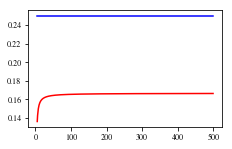

In [16]:
x = np.arange(5, 500, 1)
y = [p_nfc(0.5, r, N, rho) for N in x]
z = [p_fc(0.5, r) for N in x]
plt.plot(x, y, c="r")
plt.plot(x, z, c="b")

# Numerical

**Utility functions**

In [120]:
def default_to_regular(d):
    """Recursively convert nested defaultdicts to nested dicts.
    """
    if isinstance(d, defaultdict):
        d = {k: default_to_regular(v) for k, v in d.iteritems()}
    return d


def generate_connected_graph(nodes):
    """Return all possible edges between a set of nodes."""
    edges = set()
    for i1, n1 in enumerate(nodes):
        for i2, n2 in enumerate(nodes):
            if i2 > i1:
                edges.add((n1, n2))
    return edges


def write_pajek(layer_partition, sparse_frac=1):
    """Create pajek file from layer partition."""
    network = "*Vertices "

    nodes = set(
        n
        for l, partition in layer_partition.items()
        for c, nodes in partition.items()
        for n in nodes
    )

    network += str(len(nodes))

    for n in sorted(nodes):
        network += '\n%d "%d" 1.0' % (n, n)

    network += "\n*Intra\n#layer node node [weight]"

    for l, partition in layer_partition.items():
        for c, nodes in partition.items():
            links = generate_connected_graph(nodes)
            for a, b in ulf.shuffle_list(links)[:int(len(links)*sparse_frac)]:
                network += "\n%d %d %d 1.0" % (l, a, b)

    return network

**Infomap**

In [149]:
def run_FC(pid):
    sp.call([
        "Infomap",
        "input/network%d.net" % pid,
        "output",
        "-i", "multiplex",
        "--multiplex-relax-rate", "1.0",
        "--pajek",
        "-z"
    ])
    
def run_NFC(pid):
    sp.call([
        "Infomap",
        "input/network%d.net" % pid,
        "output",
        "-i", "multiplex",
        "--multiplex-js-relax-rate", "1.0",
        "--pajek",
        "-z"
    ])

**Model**

In [150]:
def two_overlap_benchmark_model(N, m):
    """Create two communities of size `N` that overlap by `m` nodes.

    Two communities each contain `N` nodes and overlap my `m` nodes. All
    nodes in one layer are connected and we stack layers vertically. Examples:

    N=5, m=1:          |  N=5, m=2:        |  N=3, m=2
            o o o o o  |        o o o o o  |    o o o
    o o o o o          |  o o o o o        |  o o o

    Input
    -----
    N : int
        Number of nodes in each community
    m : int
        Number of overlapping nodes between the two communities
    """
    # Create both layers, initially identical
    first_layer = np.arange(0, N)
    second_layer = np.arange(N-m, 2*N - m)

    # Produce multilayer state node label map
    partition = defaultdict(lambda: defaultdict(list))
    for l, nodes in enumerate([first_layer, second_layer]):
        for n in nodes:
            partition[l][l].append(n)

    return default_to_regular(partition)

**Do stuff**

In [151]:
def P(pid):
    """Compute fraction of weight distributed on interlayer links."""
    with open("output/network%d.net" % pid) as fp:
        net = fp.read()

    intralayer_weight = 0
    interlayer_weight = 0
    for l in re.findall(r"\d+ \d+ \d+ \d+ \d.*\d*", net):
        l = map(eval, l.split())
        if l[0] == l[2]:
            intralayer_weight += l[4]
        if l[0] != l[2]:
            interlayer_weight += l[4]

    return interlayer_weight / (intralayer_weight + interlayer_weight)

In [156]:
N = 100
deltas = np.linspace(1.0 / N, 1, N)
ms = map(int, N * deltas)
sparse_frac = 0.25

a_nu, b_nu = [], []
for m in ms:
    two_layer_partition = two_overlap_benchmark_model(N, m)

    # Format as pajek
    network = write_pajek(two_layer_partition, sparse_frac)

    # Save it
    pid_FC, pid_NFC = [np.random.randint(1, 1e9) for _ in range(2)]
    with open("input/network%d.net" % pid_FC, 'w') as fp:
        fp.write(network)
    with open("input/network%d.net" % pid_NFC, 'w') as fp:
        fp.write(network)
        
    run_FC(pid_FC)
    run_NFC(pid_NFC)
    
    a_nu.append(P(pid_FC))
    b_nu.append(P(pid_NFC))
    
    sp.call(["rm", "input/network%d.net" % pid_FC, "output/network%d.net" % pid_FC, "output/network%d.tree" % pid_FC])
    sp.call(["rm", "input/network%d.net" % pid_NFC, "output/network%d.net" % pid_NFC, "output/network%d.tree" % pid_NFC])

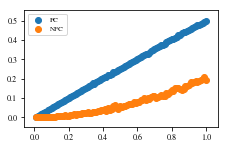

In [157]:
plt.scatter(deltas, a_nu, label="FC")
plt.scatter(deltas, b_nu, label="NFC")
plt.legend()
plt.show()

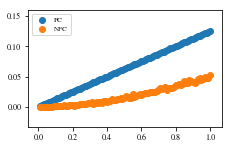

In [134]:
plt.scatter(deltas, a_nu, label="FC")
plt.scatter(deltas, b_nu, label="NFC")
plt.legend()
plt.show()

# Compare analytical and numerical

## FC

**Looks good**

ValueError: x and y must be the same size

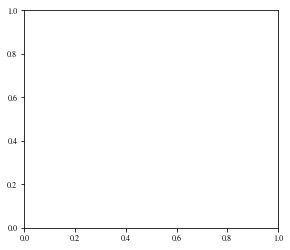

In [94]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.scatter(a_an, a_nu)
plt.subplot(1, 2, 2)
plt.scatter(deltas, a_an, label="Analytical", alpha=0.5)
plt.scatter(deltas, a_nu, label="Numerical", alpha=0.5)
plt.legend()
plt.show()
zip(a_an, a_nu)

## NFC

**Somethings weird**

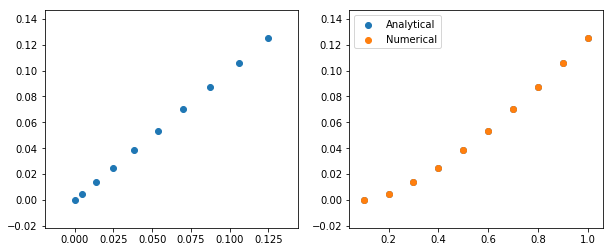

[(0.0, 0.0),
 (0.005000000000000001, 0.005000010980015319),
 (0.013636363636363641, 0.013636371859087787),
 (0.025000000000000001, 0.0249999694000178),
 (0.038461538461538464, 0.03846158173081065),
 (0.053571428571428568, 0.05357156260754448),
 (0.070000000000000021, 0.06999995589998369),
 (0.087500000000000008, 0.08750018450005163),
 (0.10588235294117647, 0.10588241011765749),
 (0.125, 0.12500011250001145)]

In [48]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.scatter(b_an, b_nu)
plt.subplot(1, 2, 2)
plt.scatter(deltas, b_an, label="Analytical")
plt.scatter(deltas, b_nu, label="Numerical")
plt.legend()
plt.show()
zip(b_an, b_nu)

# Surgeon mode

In [95]:
N = 10
deltas = np.linspace(1.0 / N, 1, N)
ms = map(int, N * deltas)

a_nu, b_nu = [], []
#for m in ms:

m = 5

two_layer_partition = two_overlap_benchmark_model(N, m)

# Format as pajek
network = write_pajek(two_layer_partition)

# Save it
pid_FC, pid_NFC = [np.random.randint(1, 1e9) for _ in range(2)]
with open("input/network%d.net" % pid_FC, 'w') as fp:
    fp.write(network)
with open("input/network%d.net" % pid_NFC, 'w') as fp:
    fp.write(network)

run_FC(pid_FC)
run_NFC(pid_NFC)

a_nu.append(P(pid_FC))
b_nu.append(P(pid_NFC))

#sp.call(["rm", "input/network%d.net" % pid_FC, "output/network%d.net" % pid_FC, "output/network%d.tree" % pid_FC])
#sp.call(["rm", "input/network%d.net" % pid_NFC, "output/network%d.net" % pid_NFC, "output/network%d.tree" % pid_NFC])

In [96]:
pid = pid_NFC

with open("output/network%d.net" % pid) as fp:
    net = fp.read()

intralayer_weight = 0
interlayer_weight = 0
for l in re.findall(r"\d+ \d+ \d+ \d+ \d.*\d*", net):
    l = map(eval, l.split())
    if l[0] == l[2]:
        intralayer_weight += l[4]
    if l[0] != l[2]:
        interlayer_weight += l[4]

print interlayer_weight / (intralayer_weight + interlayer_weight)

0.0384615817308


In [97]:
print interlayer_weight

0.7692309


In [98]:
print intralayer_weight

19.23075


In [99]:
print len(net.split("\n"))

288
